「RとStanで始めるベイズ統計モデリングによるデータ分析入門」 第5部第2章「ローカルレベルモデル」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです。


# 分析の準備
## パッケージの読み込み

In [1]:
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Meiryo"

# ホワイトノイズとランダムウォーク

## 正規ホワイトノイズ

In [2]:
np.random.seed(1)
wn = np.random.normal(loc=0, scale=1, size=100)

## 累積和をとる関数cumsumの説明

In [3]:
print(np.cumsum([1, 2, 3]))

[1 3 6]


## ランダムウォーク

In [4]:
rw = np.cumsum(wn)

## グラフを作る / 2つのグラフをまとめる

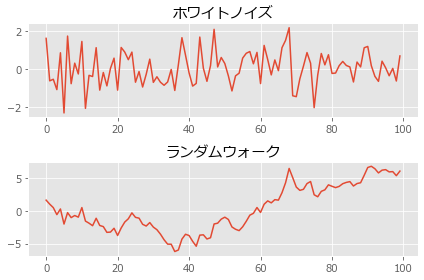

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(wn)
ax2.plot(rw)

ax1.set_title('ホワイトノイズ')
ax2.set_title('ランダムウォーク')

plt.tight_layout()
plt.show()

## 複数のホワイトノイズ・ランダムウォーク系列

In [6]:
wn_mat = np.zeros([100, 20])
rw_mat = np.zeros([100, 20])

In [7]:
np.random.seed(1)
for i in range(20):
    wn = np.random.normal(loc=0, scale=1, size=100)
    wn_mat[:,i] = wn
    rw_mat[:,i] = np.cumsum(wn)

## グラフを作る / 2つのグラフをまとめる

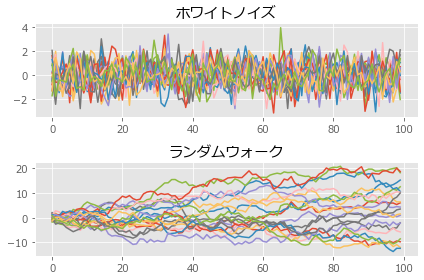

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(wn_mat)
ax2.plot(rw_mat)

ax1.set_title('ホワイトノイズ')
ax2.set_title('ランダムウォーク')

plt.tight_layout()
plt.show()

# データの読み込みとdatetimeへの変換

POXIXctの代わりにpythonではdatetime形を使用する。

## データの読み込み

In [9]:
sales_df = pd.read_csv('5-2-1-sales-ts-1.csv')

## 日付をdatetime形式にする

In [10]:
sales_df['date'] = pd.to_datetime(sales_df['date'])

## データの先頭行を表示

In [11]:
sales_df.head(n=3)

,date,sales
0,2010-01-01,23.9
1,2010-01-02,19.0
2,2010-01-03,20.3


# ローカルレベルモデルの推定

## データの準備

In [12]:
data_list = dict(y=sales_df['sales'], 
                 T=len(sales_df))

## モデルの推定

In [39]:
# stanコードの記述
stan_code = '''
data {
  int T;         // データ取得期間の長さ
  vector[T] y;   // 観測値
}

parameters {
  vector[T] mu;       // 状態の推定値(水準成分)
  real<lower=0> s_w;  // 過程誤差の標準偏差
  real<lower=0> s_v;  // 観測誤差の標準偏差
}

model {
  // 状態方程式に従い、状態が遷移する
  for(i in 2:T) {
    mu[i] ~ normal(mu[i-1], s_w);
  }
  
  // 観測方程式に従い、観測値が得られる
  for(i in 1:T) {
    y[i] ~ normal(mu[i], s_v);
  }
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
local_level_stan = stan_model.sampling(data=data_list,
                                       seed=1,
                                       n_jobs=-1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5912d60dc72bb8ffe174964dc2cf39dd NOW.


## 収束の確認

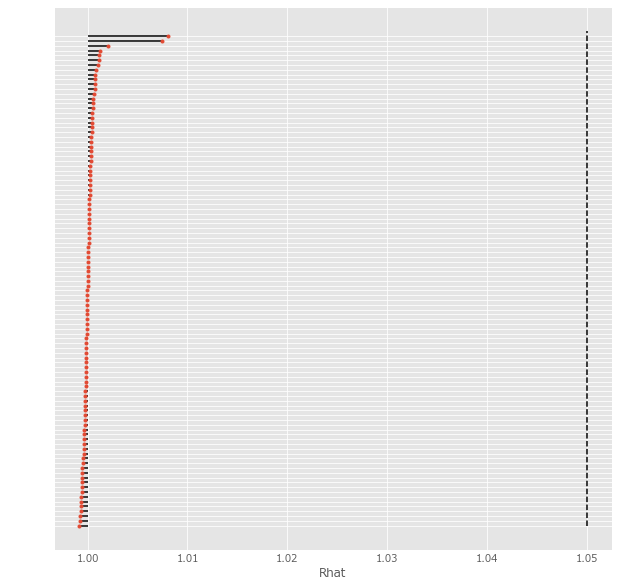

In [40]:
summary = pd.DataFrame(local_level_stan.summary()['summary'],
                       columns=local_level_stan.summary()['summary_colnames'],
                       index=local_level_stan.summary()['summary_rownames'])

plt.figure(figsize=(10, 10))
plt.hlines(y=summary['Rhat'].sort_values().index,
           xmin=1,
           xmax=summary['Rhat'].sort_values())
plt.vlines(x=1.05, ymin=0, ymax=len(summary_df['Rhat']), linestyles='--')
plt.plot(summary['Rhat'].sort_values().values,
         summary['Rhat'].sort_values().index,
         marker='.',
         linestyle='None')
plt.yticks(color='None')
plt.tick_params(length=0)
plt.xlabel('Rhat')
plt.show()

## 結果の表示

In [24]:
print(local_level_stan.stansummary(pars=["s_w", "s_v", "lp__"],
                                   probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_10622bbc8adfbe0e6ce9a8574fb3728b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_w    1.29    0.02    0.3   0.82   1.25   1.98    325   1.01
s_v    2.88  5.8e-3   0.26   2.39   2.87   3.42   2092    1.0
lp__ -225.4    1.07  18.33 -261.5 -224.9 -190.3    292   1.01

Samples were drawn using NUTS at Wed Jul 15 19:03:26 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# 結果の図示

## 生成された乱数を格納

In [25]:
mcmc_sample = local_level_stan.extract()

## Stanにおける状態を表す変数名

In [26]:
state_name = 'mu'

## 1時点目の状態の95%ベイズ信用区間と中央値を得る

In [27]:
np.percentile(mcmc_sample[state_name][:,0], q=[2.5, 50, 97.5])

array([18.11574021, 21.48727244, 24.82700243])

## すべての時点の状態の、95%ベイズ信用区間と中央値

In [28]:
result_df = pd.DataFrame(np.zeros([100,3]))
for i in range(len(sales_df)):
    result_df.iloc[i,:] = np.percentile(mcmc_sample[state_name][:,i], q=[2.5, 50, 97.5])

## 列名の変更

In [29]:
result_df.columns = ["lwr", "fit", "upr"]

## 時間軸の追加

In [30]:
result_df['time'] = sales_df['date']

## 観測値の追加

In [31]:
result_df['obs'] = sales_df['sales']

## 図示のためのデータ確認

In [32]:
result_df.head(n=3)

,lwr,fit,upr,time,obs
0,18.115740,21.487272,24.827002,2010-01-01,23.9
1,18.031008,21.008338,23.943283,2010-01-02,19.0
2,18.149184,20.930981,23.751628,2010-01-03,20.3


## 図示

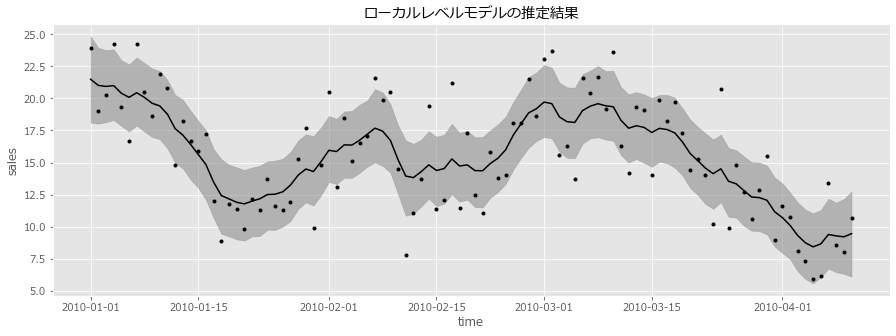

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(result_df['time'],
         result_df['obs'],
         marker='.',
         linewidth=0,
         color='black')
plt.plot(result_df['time'], 
         result_df['fit'], 
         color='black')
plt.fill_between(x=result_df['time'],
                 y1=result_df['upr'],
                 y2=result_df['lwr'],
                 color='gray',
                 alpha=0.5)
plt.xlabel('time')
plt.ylabel('sales')
plt.title('ローカルレベルモデルの推定結果')
plt.show()